# Access Computation

This tutorial demonstrates how to compute access.

## Setup

In [ ]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::physics::time::DateTime already registered; second conversion method ignored.



In [3]:
Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
AER = Physics.Coordinate.Spherical.AER
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
Access = Astrodynamics.Access

---

## Access

An access represents an object-to-object visibility period.

In this example, let's compute accesses between a fixed position on the ground and a satellite in LEO.

## Environment

Let's setup an environment (which describes where planets are, etc...):

In [4]:
environment = Environment.Default() ;

### Origin

Let's define a fixed ground position, using its geographic coordinates:

In [236]:
# Center

# latitude = Angle.Degrees(0.0)
# longitude = Angle.Degrees(0.0)
# altitude = Length.Meters(10.0)

# SvalSat

# latitude = Angle.Degrees(78.229772)
# longitude = Angle.Degrees(15.407786)
# altitude = Length.Meters(10.0)

# Test

latitude = Angle.Degrees(51.2)
longitude = Angle.Degrees(-0.6)
altitude = Length.Meters(10.0)

In [237]:
from_lla = LLA(latitude, longitude, altitude)

In [238]:
from_position = Position.Meters(from_lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())

And derive a trajectory, fixed at that position:

In [239]:
from_trajectory = Trajectory.Position(from_position)

### Target

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

In [301]:
a = Earth.EquatorialRadius + Length.Kilometers(600.0)
e = 0.000
# i = Angle.Degrees(97.5034)
i = Angle.Degrees(97.8893)
raan = Angle.Degrees(100.372)
aop = Angle.Degrees(0.0)
nu = Angle.Degrees(0.0201851)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

In [302]:
epoch = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC)

keplerian_model = Orbit.Models.Kepler(coe, epoch, environment.accessCelestialObjectWithName("Earth"), Orbit.Models.Kepler.PerturbationType.J2)

First, we need a **Two-Line Element** (TLE) set:

In [303]:
# tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
#                             "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")
tle = Orbit.Models.SGP4.TLE("1 39419U 13066D   18248.44969859 -.00000394  00000-0 -31796-4 0  9997",
                            "2 39419  97.6313 314.6863 0012643 218.7350 141.2966 14.93878994260975")

To setup a **SGP4** orbital model:

In [304]:
sgp4_model = Orbit.Models.SGP4(tle)

In [305]:
orbital_model = keplerian_model
# orbital_model = sgp4_model

We then obtain the satellite orbit (which is a trajectory):

In [306]:
environment = Environment.Default()
satellite_orbit = Orbit(orbital_model, environment.accessCelestialObjectWithName("Earth"))

### Access

Now that the origin and the target trajectories is well defined, we can compute the access.

Let's first define an **interval of interest**:

In [307]:
start_instant = Instant.DateTime(DateTime.Parse("2018-01-01 00:00:00"), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime.Parse("2018-02-01 00:00:00"), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

In [308]:
environment = Physics.Environment.Default() ;

Then, using an **Access Generator**, we can compute the accesses within the intervals of interest:

In [309]:
access_generator = Access.Generator(environment) ;

accesses = access_generator.computeAccesses(interval, from_trajectory, satellite_orbit) ;

In [310]:
# states = satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))

And format the output using a dataframe:

In [311]:
accesses_df = pd.DataFrame([[str(access.getType()), repr(access.getAcquisitionOfSignal()), repr(access.getTimeOfClosestApproach()), repr(access.getLossOfSignal()), repr(access.getDuration())] for access in accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])

In [312]:
len(accesses_df)

218

In [313]:
# accesses_df

In [339]:
dts = [(second_access.getAcquisitionOfSignal() - first_access.getAcquisitionOfSignal()) for [first_access, second_access] in zip(accesses, accesses[1:])]

In [340]:
len(dts)

217

In [341]:
min(dts)

01:30:23.225.447.239

In [342]:
max(dts)

10:04:30.099.649.430

In [343]:
import statistics 
statistics.mean(dts)

TypeError: can't convert type 'Duration' to numerator/denominator

In [344]:
# accesses

In [345]:
sorted(dts)

[01:30:23.225.447.239,
 01:30:23.636.637.927,
 01:30:24.110.381.306,
 01:30:24.646.877.646,
 01:31:09.327.846.766,
 01:31:09.646.454.752,
 01:31:10.001.647.175,
 01:31:10.395.129.919,
 01:31:45.195.038.618,
 01:31:45.483.772.158,
 01:31:45.797.651.411,
 01:31:46.139.184.237,
 01:32:16.763.132.215,
 01:32:17.058.087.586,
 01:32:17.374.489.009,
 01:32:45.515.917.541,
 01:32:45.801.639.855,
 01:32:46.104.638.278,
 01:32:46.426.301.299,
 01:33:12.739.418.150,
 01:33:13.021.080.493,
 01:33:13.316.964.804,
 01:33:13.627.814.949,
 01:33:18.597.364.426,
 01:33:19.644.604.325,
 01:33:20.616.515.279,
 01:33:21.515.133.976,
 01:33:39.018.201.827,
 01:33:39.299.028.219,
 01:33:39.591.726.063,
 01:33:39.896.707.535,
 01:34:03.652.391.730,
 01:34:04.258.187.412,
 01:34:04.745.807.648,
 01:34:04.820.038.677,
 01:34:05.028.131.604,
 01:34:05.320.460.201,
 01:34:05.339.441.299,
 01:34:05.623.123.348,
 01:34:30.222.868.321,
 01:34:30.508.623.719,
 01:34:30.802.891.552,
 01:34:31.106.103.658,
 01:34:31.7

### Output

Let's calculate the geographic coordinate of the satellite, during access:

In [319]:
def compute_time_lla_aer_state (state):
    
    lla = LLA.Cartesian(state.getPosition().inFrame(Frame.ITRF(), state.getInstant()).getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)
    
    aer = AER.FromPositionToPosition(from_position, state.getPosition().inFrame(Frame.ITRF(), state.getInstant()))

    return [state.getInstant(), float(lla.getLatitude().inDegrees()), float(lla.getLongitude().inDegrees()), float(lla.getAltitude().inMeters()), float(aer.getAzimuth().inDegrees()), float(aer.getElevation().inDegrees()), float(aer.getRange().inMeters())]

def compute_access_geometry (access):

    return [compute_time_lla_aer_state(state) for state in satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))]

In [320]:
access_geometry_dfs = [pd.DataFrame(compute_access_geometry(access), columns=['Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Elevation', 'Range']) for access in accesses] ;

In [321]:
access_geometry_dfs[0].head()

,Time,Latitude,Longitude,Altitude,Azimuth,Elevation,Range
0,-- Instant -----------------------------------...,27.380158,-5.889192,604495.082037,344.655811,37.969496,2.850647e+06
1,-- Instant -----------------------------------...,31.065615,-6.799683,605661.650308,341.032261,33.592809,2.463214e+06
2,-- Instant -----------------------------------...,34.744877,-7.762958,606909.432351,336.497659,28.198192,2.088758e+06
3,-- Instant -----------------------------------...,38.416892,-8.792183,608217.323282,330.586801,21.178775,1.737675e+06
4,-- Instant -----------------------------------...,42.080402,-9.904217,609563.236713,322.550978,11.575436,1.429176e+06


And plot the geometries onto a map:

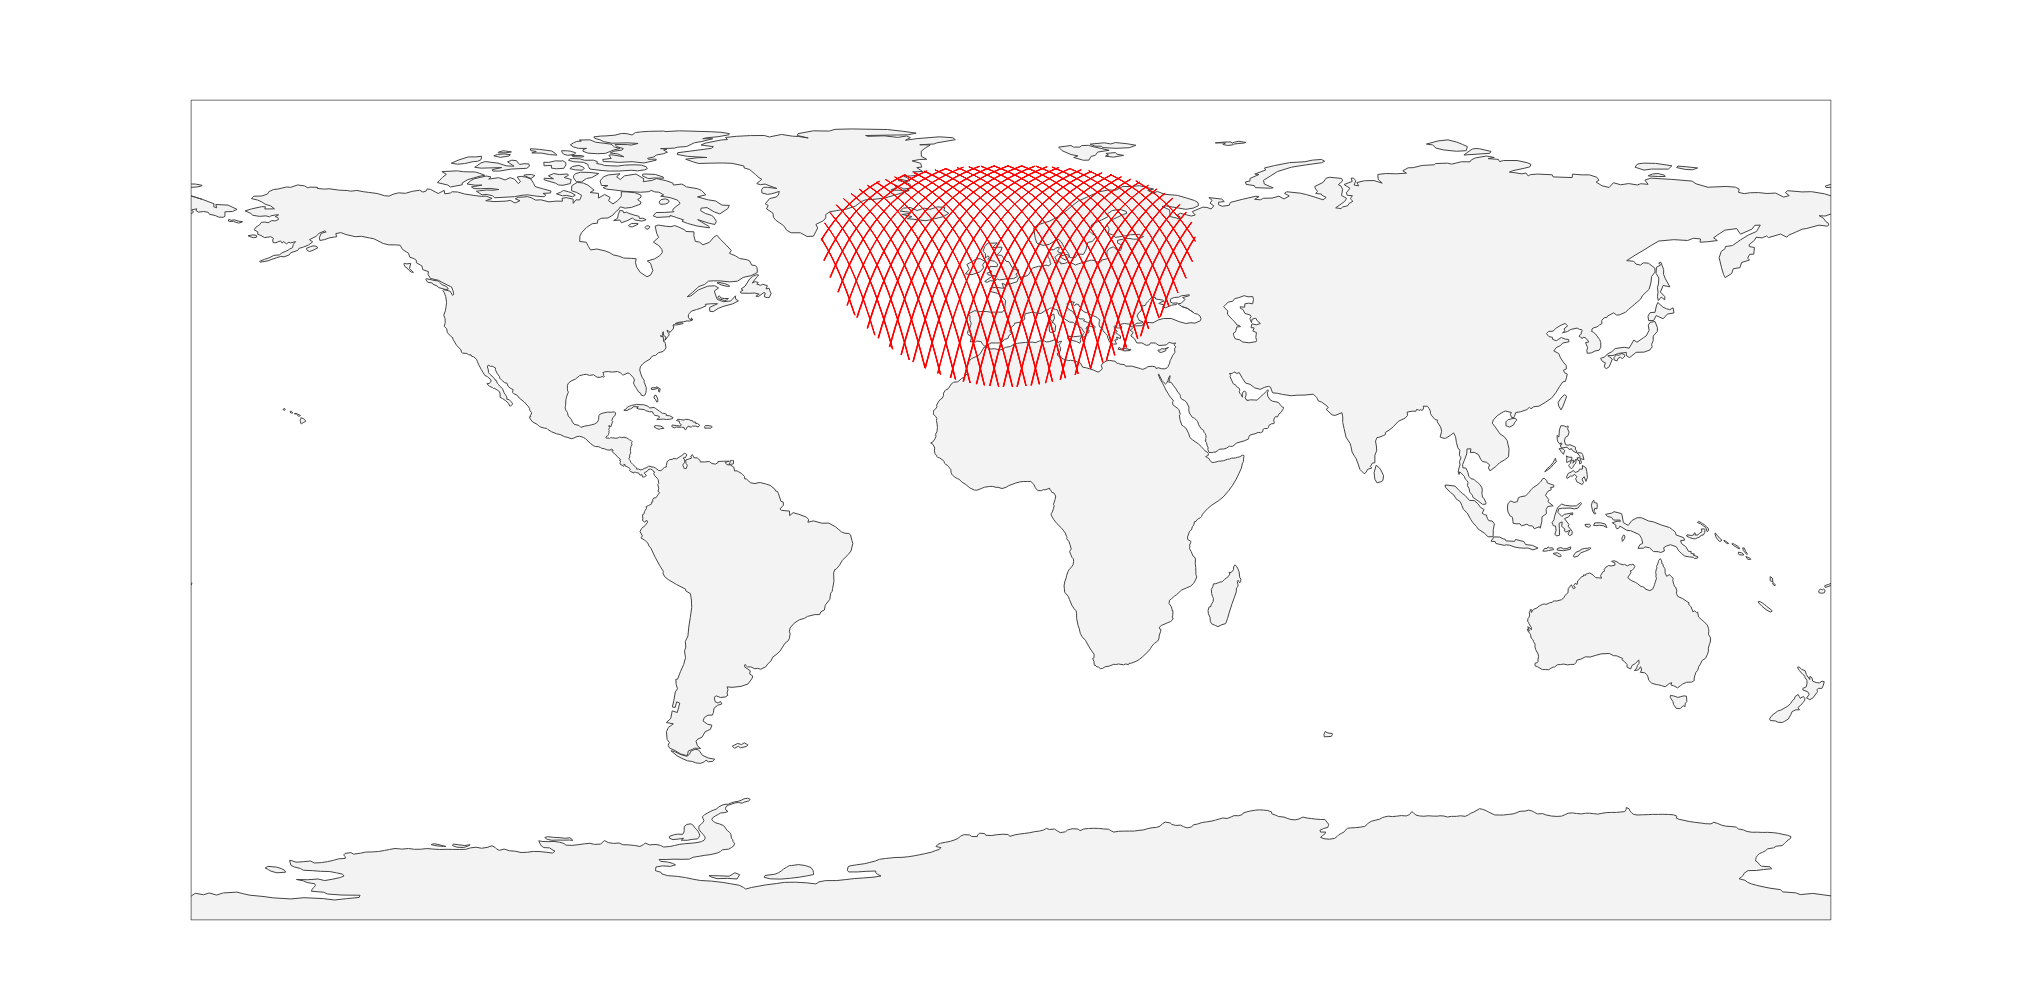

In [322]:
access_paths = []

for access_geometry_df in access_geometry_dfs:
    
    access_paths.append(
        dict(
            type = 'scattergeo',
            lon = access_geometry_df['Longitude'],
            lat = access_geometry_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            )
        )
    )
    
layout = dict(
        title = None,
        showlegend = False,
        height= 1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=access_paths, layout=layout)
iplot(fig)